# Text Classification

In [101]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Read pre-processed data

In [115]:
import csv

data = pd.read_csv('train.csv')
df_eval = pd.read_csv('validation.csv')
df_test = pd.read_csv('test.csv')

x_train, y_train = data['cleaned_text'].values.tolist(), data['label_id'].values.tolist()
x_valid, y_valid = df_eval['cleaned_text'].values.tolist(), df_eval['label_id'].values.tolist()
x_test, y_test = df_test['cleaned_text'].values.tolist(), df_test['label_id'].values.tolist()

print(len(x_train))
print(len(x_valid))
print(len(x_test))

966
75
74


## Tokenize data
#### assign a number to each word, set a 64 number of words for each text and pad with 0 in the case texts with lenght les than 64

In [116]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(x_train)
t.word_index['<PAD>'] = 0

max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('سیاهان', 14630), ('<PAD>', 0), 1)

In [117]:
train_sequences = t.texts_to_sequences(x_train)
valid_sequences = t.texts_to_sequences(x_valid)
test_sequences = t.texts_to_sequences(x_test)

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=14631
Number of Documents=966


## Plot size of texts

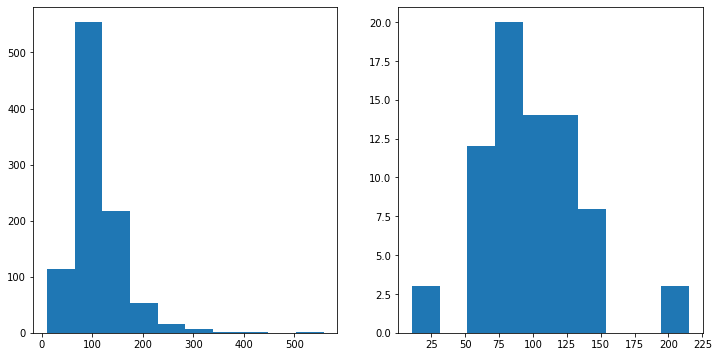

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [118]:
MAX_SEQUENCE_LENGTH = 64

# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_valid = sequence.pad_sequences(valid_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_valid.shape, X_test.shape

print(X_test[1])

[  173   198   368   304  4062     1   525    71   446  2166   221     2
  2333  1212     1   368  2749     1  2794   689   215   583   917     1
     1   368     1 11364  2096     2  4282  9056     1     1  2794   215
   583   917  2323     2     1  4483  1736     1  2794   215   583   917
  2323     4   792     8   113     3  2957     2  2333   261  1868     1
     2     1   586   360]


## encode labels

In [119]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

print(sum(y_test))

VOCAB_SIZE = len(t.word_index)
print(VOCAB_SIZE)

20
14631


## MODEL
#### CNN model containing an embedding layer, Conv layers, maxpoolings and Dense layers

In [120]:
from tensorflow.keras.optimizers import RMSprop

EMBED_SIZE = 64
EPOCHS=2
BATCH_SIZE=4

EVERY_EPOCH = 1000
LEARNING_RATE = 2e-5

train_steps = len(X_train) // BATCH_SIZE
valid_steps = len(X_valid) // BATCH_SIZE

# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 64, 64)            936384    
                                                                 
 conv1d_63 (Conv1D)          (None, 64, 64)            16448     
                                                                 
 max_pooling1d_63 (MaxPoolin  (None, 32, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_64 (Conv1D)          (None, 32, 32)            8224      
                                                                 
 max_pooling1d_64 (MaxPoolin  (None, 16, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_65 (Conv1D)          (None, 16, 16)          

## Fit model

In [112]:
# Fit the model
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          epochs=EPOCHS, 
          steps_per_epoch=train_steps,
          validation_steps=valid_steps,
          batch_size=BATCH_SIZE, 
          validation_batch_size=BATCH_SIZE,
          verbose=1)

Epoch 1/2
241/241 [==============================] - 2s 10ms/step - loss: 0.2605 - accuracy: 0.9015 - val_loss: 0.7089 - val_accuracy: 0.7222
Epoch 2/2
241/241 [==============================] - 2s 10ms/step - loss: 0.0805 - accuracy: 0.9761 - val_loss: 0.7727 - val_accuracy: 0.7361


In [113]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


predict_x = model.predict(X_test) 
predictions = np.argmax(predict_x, axis=1)
predictions = predict_x >0.5

3/3 [==============================] - 0s 7ms/step - loss: 0.9093 - accuracy: 0.6622
Accuracy: 66.22%


## Results and Confusion matrix

In [114]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.75      0.80      0.77        54
           1       0.35      0.30      0.32        20

    accuracy                           0.66        74
   macro avg       0.55      0.55      0.55        74
weighted avg       0.65      0.66      0.65        74



,negative,positive
negative,43,11
positive,14,6
